<a href="https://colab.research.google.com/github/SarahGraceMaclean/Image-super-resolution/blob/master/ISR_image_super_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ISR

     |████████████████████████████████| 92.5MB 1.3MB/s 
     |████████████████████████████████| 17.3MB 36.7MB/s 
     |████████████████████████████████| 368kB 43.3MB/s 
     |████████████████████████████████| 3.2MB 36.0MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Successfully uninstalled numpy-1.16.4
  Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tensorflow-estimator-1.14.0
  Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-

# **Training**

Install training data and extract in google drive

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir("drive/My Drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [12]:
#!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip
#!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip
#!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
#!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip

--2019-07-16 14:50:47--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip [following]
--2019-07-16 14:50:48--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 925390592 (883M) [application/zip]
Saving to: ‘DIV2K_train_LR_bicubic_X2.zip’

DIV2K_train_LR_bicu 100%[===================>] 882.52M  11.2MB/s    in 70s     

2019-07-16 14:51:58 (12.7 MB/s) - ‘DIV2K_train_LR_bicubic_X2.zip’ saved [925390592/925390592]

--2019-07-16 14:52:00--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X

In [0]:
#!mkdir div2k
#!unzip -q DIV2K_valid_LR_bicubic_X2.zip -d div2k
#!unzip -q DIV2K_train_LR_bicubic_X2.zip -d div2k
#!unzip -q DIV2K_train_HR.zip -d div2k
#!unzip -q DIV2K_valid_HR.zip -d div2k

In [0]:
import numpy as np
from PIL import Image

img = Image.open('ISR-Image Super Resolution/rose.jpg')
lr_img = np.array(img)

In [4]:
from ISR.models import RRDN
from ISR.models import Discriminator
from ISR.models import Cut_VGG19

Using TensorFlow backend.


In [5]:
lr_train_patch_size = 40
layers_to_extract = [5, 9]
scale = 2
hr_train_patch_size = lr_train_patch_size * scale

rrdn  = RRDN(arch_params={'C':4, 'D':3, 'G':64, 'G0':64, 'T':10, 'x':scale}, patch_size=lr_train_patch_size)
f_ext = Cut_VGG19(patch_size=hr_train_patch_size, layers_to_extract=layers_to_extract)
discr = Discriminator(patch_size=hr_train_patch_size, kernel_size=3)

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 2s 0us/step


In [0]:
from ISR.train import Trainer
loss_weights = {
  'generator': 0.0,
  'feature_extractor': 0.0833,
  'discriminator': 0.01
}
losses = {
  'generator': 'mae',
  'feature_extractor': 'mse',
  'discriminator': 'binary_crossentropy'
} 

log_dirs = {'logs': './logs', 'weights': './weights'}

learning_rate = {'initial_value': 0.0004, 'decay_factor': 0.5, 'decay_frequency': 30}

flatness = {'min': 0.0, 'max': 0.15, 'increase': 0.01, 'increase_frequency': 5}

trainer = Trainer(
    generator=rrdn,
    discriminator=discr,
    feature_extractor=f_ext,
    lr_train_dir='div2k/DIV2K_train_LR_bicubic/X2/',
    hr_train_dir='div2k/DIV2K_train_HR/',
    lr_valid_dir='div2k/DIV2K_train_LR_bicubic/X2/',
    hr_valid_dir='div2k/DIV2K_train_HR/',
    loss_weights=loss_weights,
    learning_rate=learning_rate,
    flatness=flatness,
    dataname='div2k',
    log_dirs=log_dirs,
    weights_generator=None,
    weights_discriminator=None,
    n_validation=40,
)

In [9]:
trainer.train(
    epochs=1,
    steps_per_epoch=20,
    batch_size=4,
    monitored_metrics={'val_PSNR_Y': 'max'}
)


Training details:
  training_parameters: 
    metrics: {'generator': <function PSNR_Y at 0x7f82b55f3950>}
    losses: {'generator': 'mae', 'discriminator': 'binary_crossentropy', 'feature_extractor': 'mse'}
    adam_optimizer: {'beta1': 0.9, 'beta2': 0.999, 'epsilon': None}
    learning_rate: {'initial_value': 0.0004, 'decay_factor': 0.5, 'decay_frequency': 30}
    flatness: {'min': 0.0, 'max': 0.15, 'increase': 0.01, 'increase_frequency': 5}
    n_validation: 40
    dataname: div2k
    fallback_save_every_n_epochs: 2
    log_dirs: {'logs': './logs', 'weights': './weights'}
    loss_weights: {'generator': 0.0, 'feature_extractor': 0.0833, 'discriminator': 0.01}
    hr_valid_dir: div2k/DIV2K_train_HR/
    lr_valid_dir: div2k/DIV2K_train_LR_bicubic/X2/
    hr_train_dir: div2k/DIV2K_train_HR/
    lr_train_dir: div2k/DIV2K_train_LR_bicubic/X2/
    lr_patch_size: 40
    steps_per_epoch: 20
    batch_size: 4
    starting_epoch: 0
  generator: 
    name: rrdn
    parameters: {'C': 4, 'D': 3,

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████| 20/20 [13:31<00:00, 38.87s/it]
Epoch 0 took      812.0s


160/160 [==============================] - 316s 2s/step


val_PSNR_Y is NOT among the model metrics, removing it.
{'val_loss': 0.9870750326663256, 'val_generator_loss': 0.4177329733967781, 'val_discriminator_loss': 0.6978200376033783, 'val_feature_extractor_loss': 19.876998054981232, 'val_generator_PSNR_Y': 8.348980349302291, 'train_d_real_loss': 0.4255448, 'train_d_real_acc': 0.88625, 'train_d_fake_loss': 0.11730569, 'train_d_fake_acc': 0.995625, 'train_loss': 2.1037529, 'train_generator_loss': 0.5423073, 'train_discriminator_loss': 3.2212958, 'train_feature_extractor_loss': 41.475063, 'train_generator_PSNR_Y': 6.267912}


# **Prediction**

Download the pretrained weights to a Drive folder named weights

In [13]:
!wget https://github.com/idealo/image-super-resolution/raw/master/weights/sample_weights/rdn-C6-D20-G64-G064-x2/ArtefactCancelling/rdn-C6-D20-G64-G064-x2_ArtefactCancelling_epoch219.hdf5
!wget https://github.com/idealo/image-super-resolution/raw/master/weights/sample_weights/rdn-C6-D20-G64-G064-x2/PSNR-driven/rdn-C6-D20-G64-G064-x2_PSNR_epoch086.hdf5
!wget https://github.com/idealo/image-super-resolution/raw/master/weights/sample_weights/rdn-C3-D10-G64-G064-x2/PSNR-driven/rdn-C3-D10-G64-G064-x2_PSNR_epoch134.hdf5
!mkdir weights
!mv *.hdf5 weights

--2019-07-17 08:27:49--  https://github.com/idealo/image-super-resolution/raw/master/weights/sample_weights/rdn-C6-D20-G64-G064-x2/ArtefactCancelling/rdn-C6-D20-G64-G064-x2_ArtefactCancelling_epoch219.hdf5
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/idealo/image-super-resolution/master/weights/sample_weights/rdn-C6-D20-G64-G064-x2/ArtefactCancelling/rdn-C6-D20-G64-G064-x2_ArtefactCancelling_epoch219.hdf5 [following]
--2019-07-17 08:27:50--  https://media.githubusercontent.com/media/idealo/image-super-resolution/master/weights/sample_weights/rdn-C6-D20-G64-G064-x2/ArtefactCancelling/rdn-C6-D20-G64-G064-x2_ArtefactCancelling_epoch219.hdf5
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githu

In [0]:
import numpy as np
from PIL import Image

Download a sample image or use one which is already saved to the Drive:

In [0]:
!wget http://images.math.cnrs.fr/IMG/png/section8-image.png
!mkdir -p data/input/test_images
!mv *.png data/input/test_images

or

In [0]:
img = Image.open('ISR-Image Super Resolution/rose.jpg')
lr_img = np.array(img)

View origional image

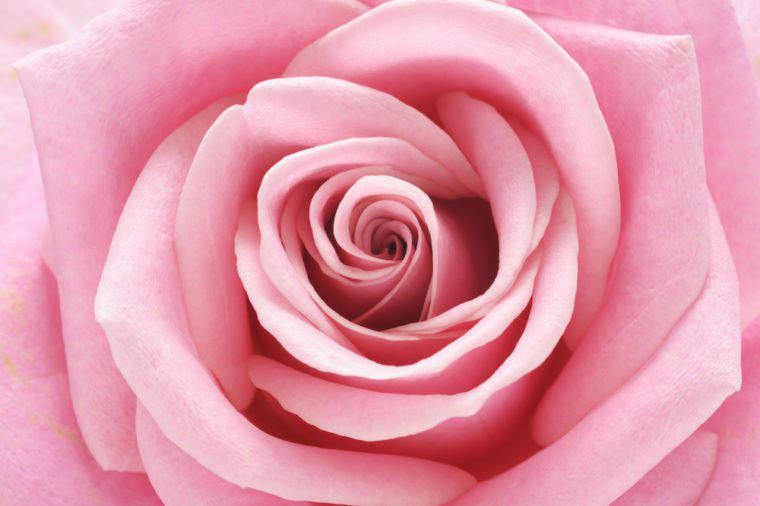

In [32]:
img

Using downloaded pretrained weights (chose which model from large,small or noise cancelling and enhancing) then predict your chosen image

Large RDN model:

rdn = RDN(arch_params={'C': 6, 'D':20, 'G':64, 'G0':64, 'x':2})

rdn.model.load_weights('weights/rdn-C6-D20-G64-G064-x2_PSNR_epoch086.hdf5')



Small RDN model:

rdn = RDN(arch_params={'C': 3, 'D':10, 'G':64, 'G0':64, 'x':2})

rdn.model.load_weights('weights/rdn-C3-D10-G64-G064-x2_PSNR_epoch134.hdf5')


Noise cancelling and detail enhancing:

rdn = RDN(arch_params={'C':6, 'D':20, 'G':64, 'G0':64, 'x':2})

rdn.model.load_weights('weights/rdn-C6-D20-G64-G064x2_ArtefactCancelling_epoch219.hdf5')

In [0]:
from ISR.models import RDN

rdn = RDN(arch_params={'C':6, 'D':20, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('weights/rdn-C6-D20-G64-G064-x2_ArtefactCancelling_epoch219.hdf5') #this is the directory and file of the downloaded pretrained weights (if trained your own network change the path and file to your saved weights)

sr_img = rdn.predict(lr_img)
Image.fromarray(sr_img)

sr_image_save = Image.fromarray(sr_img)
sr_image_save.save('ISR-Image Super Resolution/rose-SR.jpg')


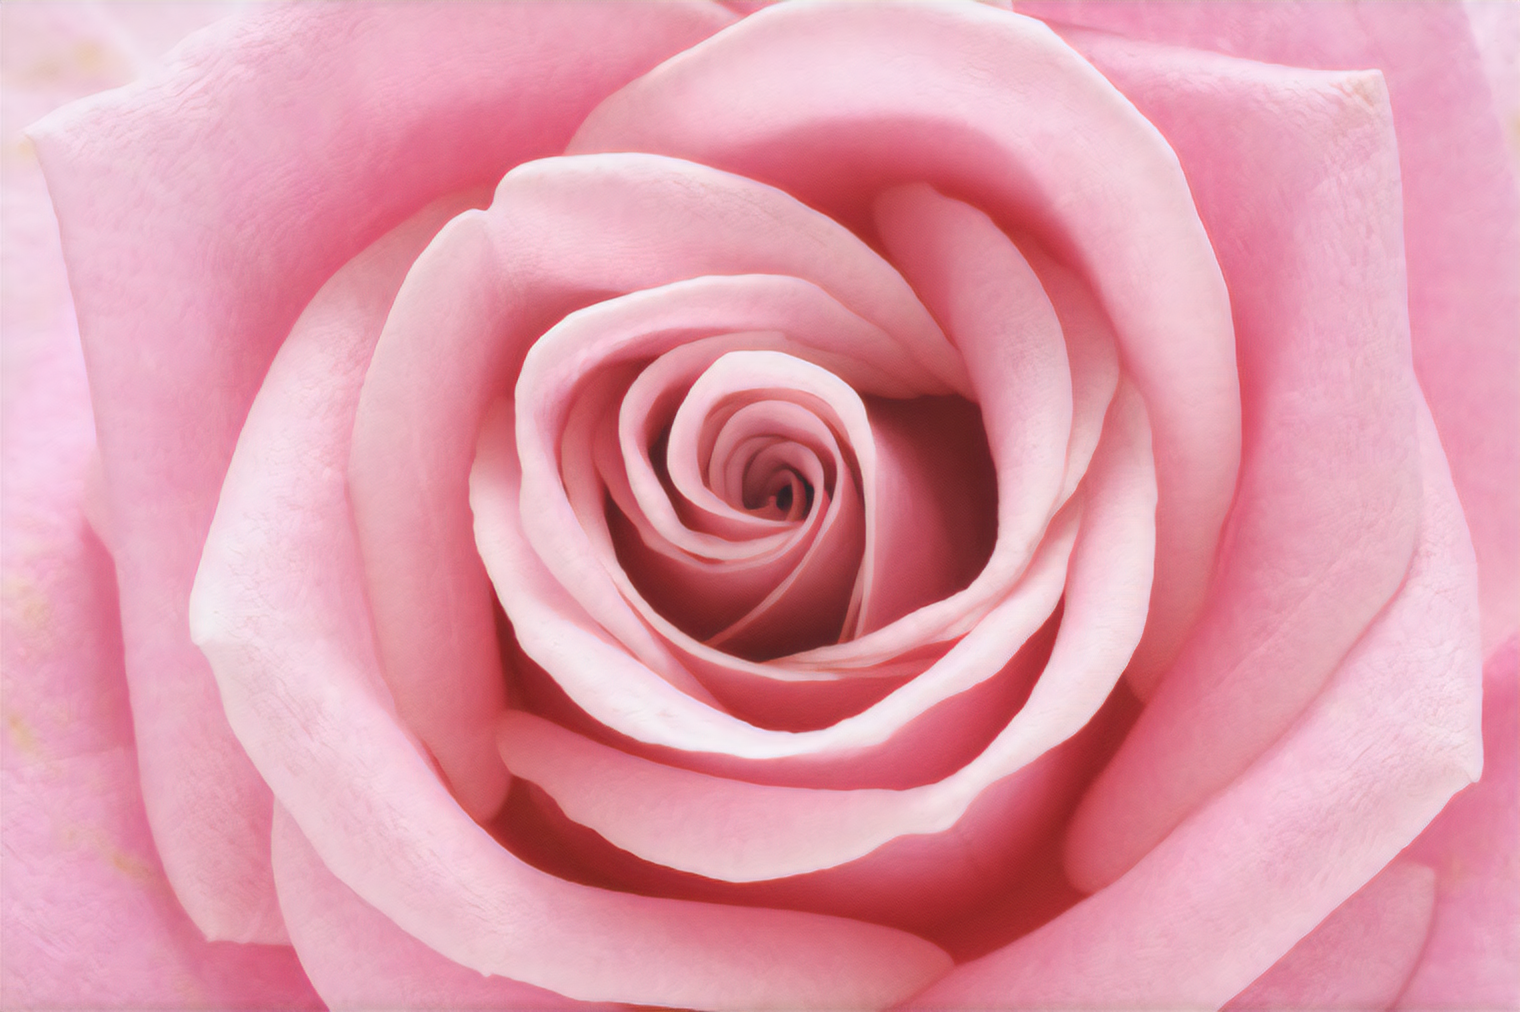

In [34]:
Image.fromarray(sr_img)

Now to test the network, compress an image and then try upsize it again

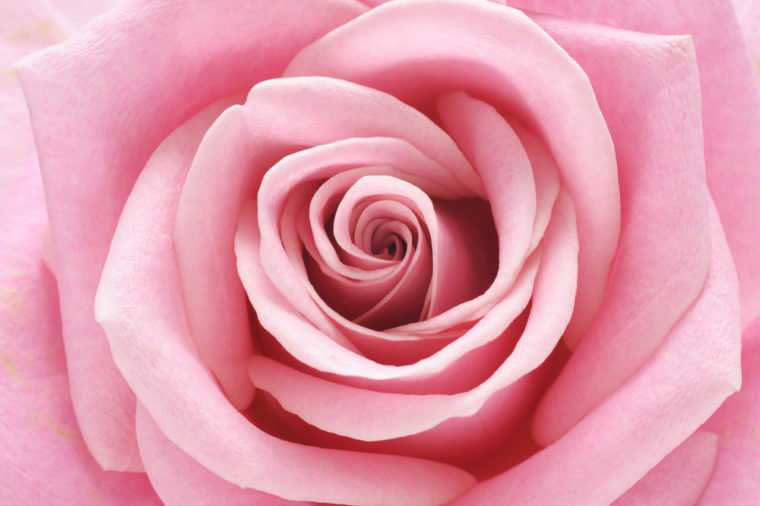

In [23]:
img.save('ISR-Image Super Resolution/rose_compressed.jpeg','JPEG', dpi=[300, 300], quality=50)
compressed_img = Image.open('ISR-Image Super Resolution/rose_compressed.jpeg')

compressed_img

Bicubic Scaling

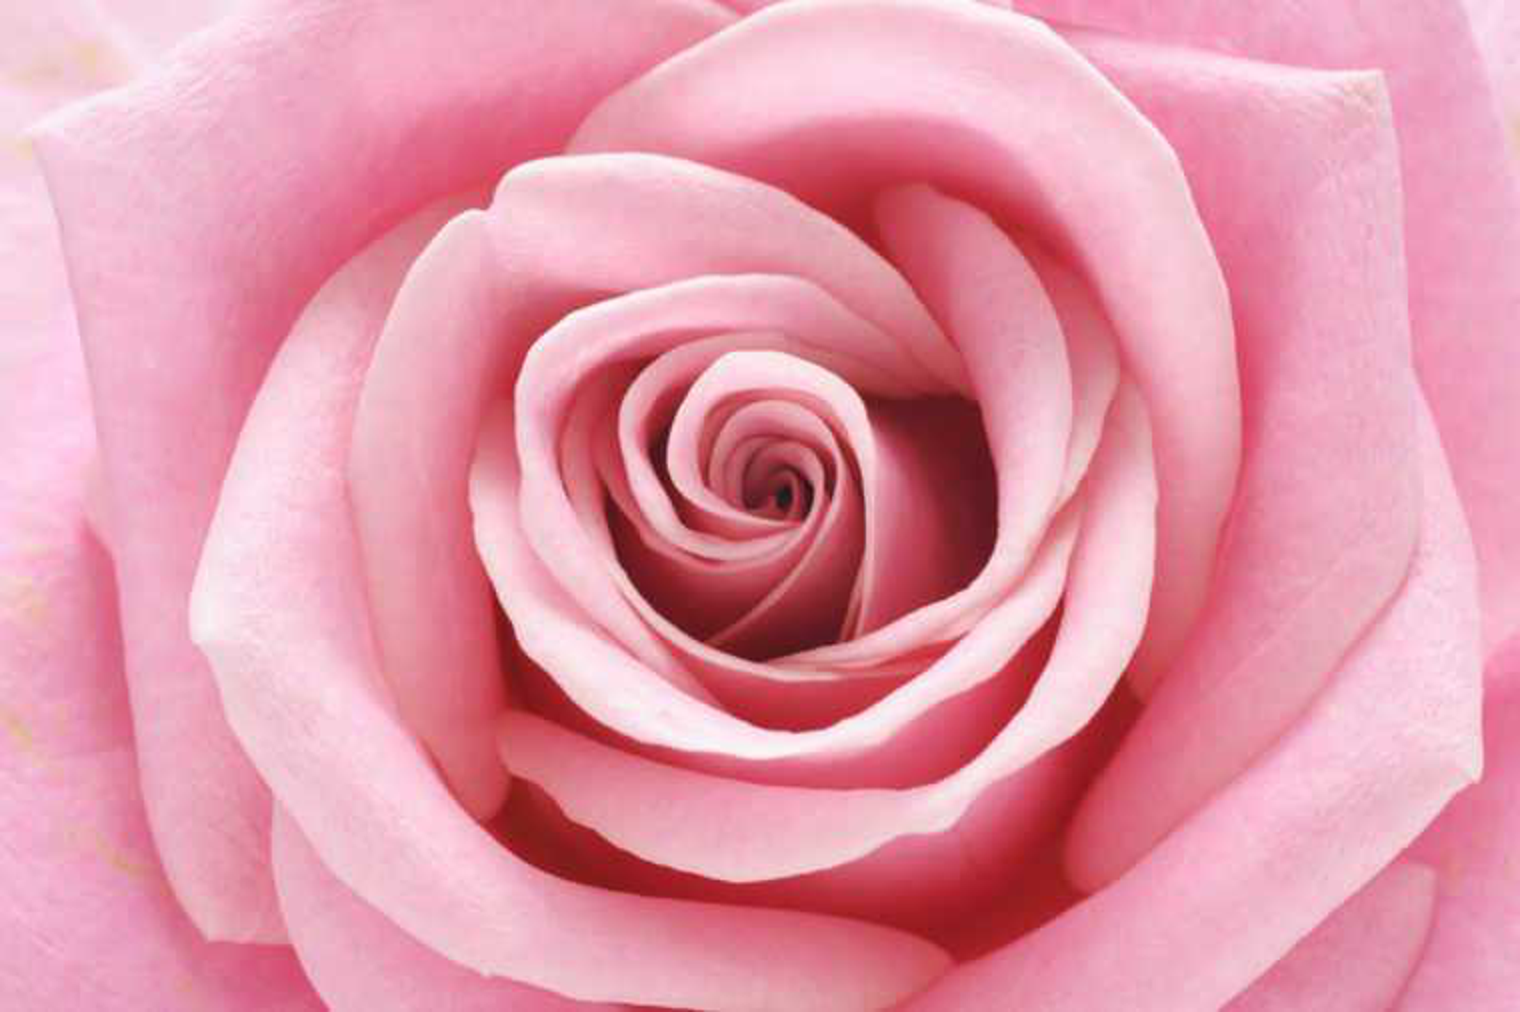

In [24]:
compressed_img.resize(size=(compressed_img.size[0]*2, compressed_img.size[1]*2), resample=Image.BICUBIC)

Large RDN model 

In [0]:
rdn = RDN(arch_params={'C': 6, 'D':20, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('weights/rdn-C6-D20-G64-G064-x2_PSNR_epoch086.hdf5')
sr_img = rdn.predict(np.array(compressed_img))
Image.fromarray(sr_img)

Small RDN model

In [0]:
rdn = RDN(arch_params={'C': 3, 'D':10, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('weights/rdn-C3-D10-G64-G064-x2_PSNR_epoch134.hdf5')
sr_img = rdn.predict(np.array(compressed_img))
Image.fromarray(sr_img)

Large RDN model with noise canceling and detail enhancing

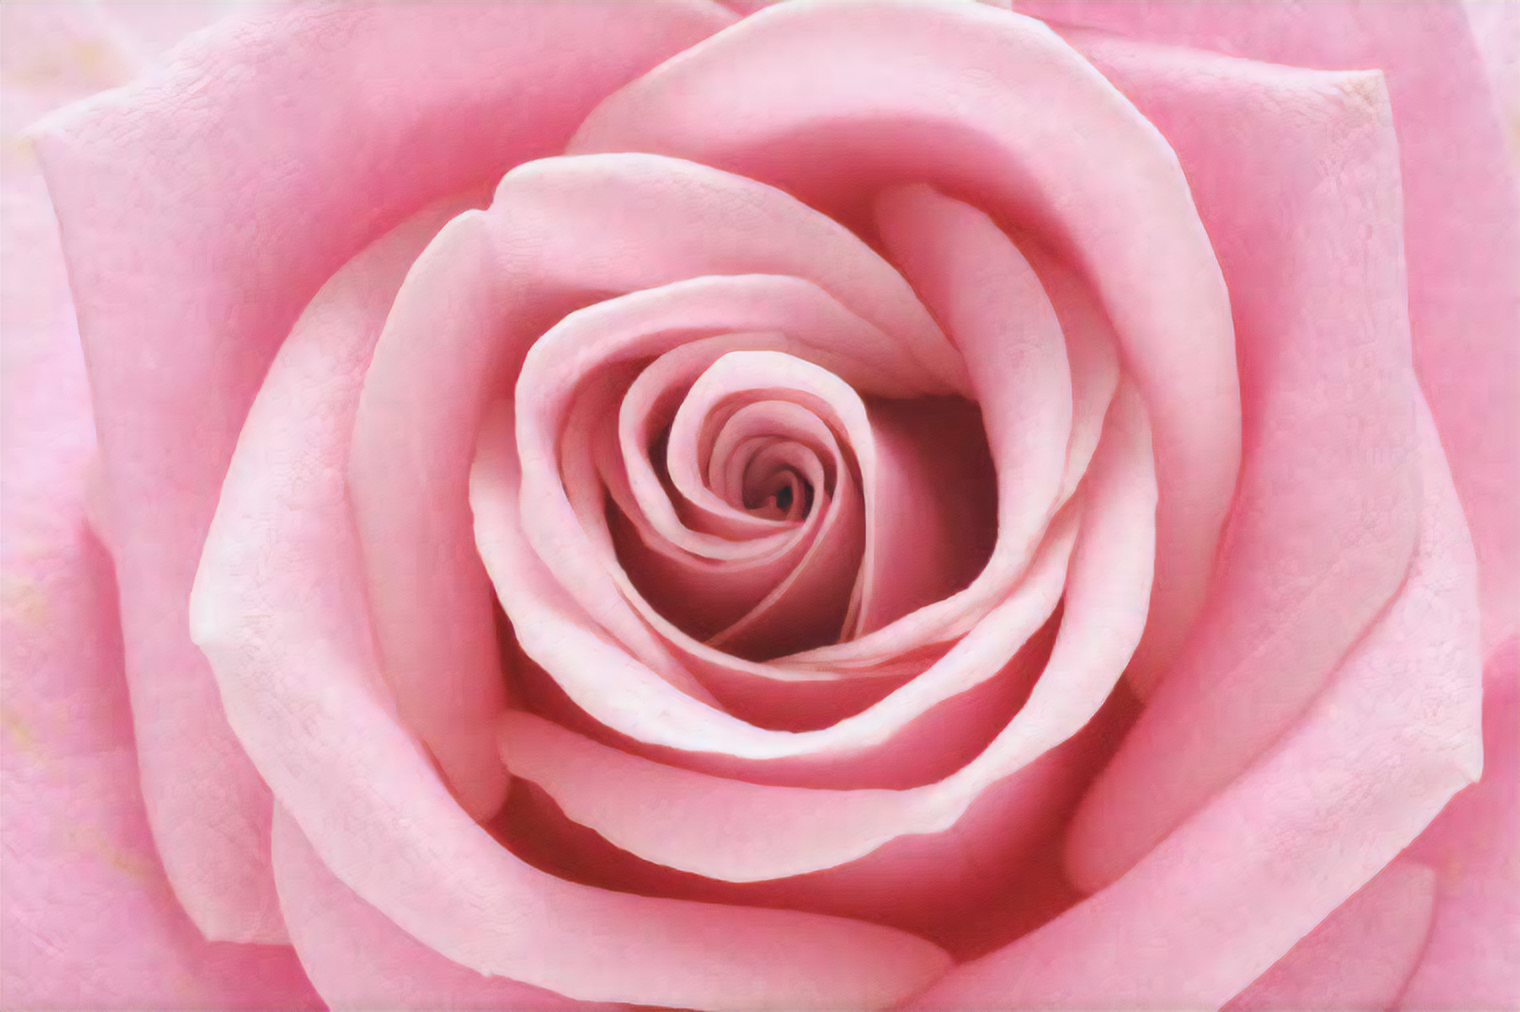

In [25]:
rdn = RDN(arch_params={'C': 6, 'D':20, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('weights/rdn-C6-D20-G64-G064-x2_ArtefactCancelling_epoch219.hdf5')
sr_img = rdn.predict(np.array(compressed_img))
Image.fromarray(sr_img)

You can also use the predictor class to run the model on entire folders

In [0]:
from ISR.predict import Predictor
!mkdir -p SR-data/output
predictor = Predictor(input_dir='data/input/test_images/')
predictor.get_predictions(model=rdn, weights_path='weights/rdn-C6-D20-G64-G064-x2_ArtefactCancelling_epoch219.hdf5')